This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [1]:
import netCDF4
import os, glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._netcdf_line_utils import NetCDFLineUtils, NetCDFPointUtils
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, plotting_utils,borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import gc
import sqlalchemy as db
from sqlalchemy import create_engine, event

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf"

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdKeep2019_DataResp_cor2DLogOrd.nc')
EM_dataset = netCDF4.Dataset(EM_path)


# Open the file with the many layer model conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
cond_dataset = netCDF4.Dataset(cond_path)


# Open the file with the few layer model conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

flm_cond_path = os.path.join(ncdir,'OrdKeep2019_cor2DLogOrd_Mlm2Flm_WLim.nc')
flm_cond_dataset = netCDF4.Dataset(flm_cond_path)


In [3]:
cond_dataset.variables['conductivity']

<class 'netCDF4._netCDF4.Variable'>
float32 conductivity(point, layer)
    _FillValue: 0.0
    long_name: Layer conductivity
    units: S/m
unlimited dimensions: 
current shape = (641851, 30)
filling on

In [4]:
# airborne EM inversions and data are typically visualised on a line by line basis

# To utilise the geophys_utils for line data create a NetCDFLineUtils for each dataset

EM_line_utils = NetCDFLineUtils(EM_dataset)
cond_line_utils = NetCDFLineUtils(cond_dataset)
flm_line_utils = NetCDFLineUtils(flm_cond_dataset)
cond_point_utils = NetCDFPointUtils(cond_dataset)

# Display the lines for the conductivity mode

wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

In [5]:
# Create an instance of plots for gridding the data
plots = plot_utils.ConductivitySectionPlot(cond_dataset, EM_dataset)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'tx_height_measured', 'depth_of_investigation']

plots.EM_variables  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']

lines = [302801]

# Define the resolution of th sections
xres, yres = 20., 2.

gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed = False,
                                    return_dict = True)

In [6]:
def format_panels(axes, panel_settings, plot_settings):
    
    # Iterate through the axes and set the aspect if it is included in the panel settings
    
    grid_ratio = {}
    
    height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                    'height_ratio')
    
    for i, ax in enumerate(axes):
        panel = panel_settings['panel_' + str(i + 1)]

        if 'vertical_exaggeration' in panel['panel_kwargs']:
            # Assert it is a grid
            assert panel['plot_type'] == 'grid'
            
            # Get the vertical exageration
            vexag = panel['panel_kwargs']['vertical_exaggeration']
            
            # Set the aspect
            ax.set_aspect(vexag)
            
            # get teh grid ratio
            grid_ratio[i + 1] = (np.diff(ax.get_ylim())/np.diff(ax.get_xlim())) * vexag
    
    ax_pos = {}
    # Iterate through the axes and get position
    for i, ax in enumerate(ax_array):
        # Find the position of each axis
         ax_pos[i] = ax.get_position(original = False)
        
    # Use this to set the size of the graph
    bottom_margin = plot_settings['bottom_margin']
    top_margin   = plot_settings['top_margin']
    panel_vgap   = plot_settings['panel_vgap']
    plot_width = plot_settings['plot_width']
    
    # Find the height
    
    plot_height = 0.
    plot_height = plot_height + bottom_margin + top_margin + (len(panel_settings) - 1) * panel_vgap
    
    # For gridded items find the axis hgiht
    for item in grid_ratio:
            
        # Get the wdith of the axis in inches
        ax_width = np.min([x.width for x in ax_pos.values()]) * plot_width
        cond_ax_height = ax_width * grid_ratio[item]
        
        plot_height += cond_ax_height
    
    # Now add the height for the other panels
    
    for i in range(len(height_ratios)):
        panel = panel_settings['panel_' + str(i + 1)]
        
        if not 'vertical_exaggeration' in panel['panel_kwargs']:
        
            plot_height += cond_ax_height * (height_ratios[i]/height_ratios[item - 1])
        
    print(plot_height)
    plt.gcf().set_size_inches(plot_width, plot_height)
    
    #margins = {  #     vvv margin in inches
    #"left"   :     1.5 / figsize[0],
    #"bottom" :     0.8 / figsize[1],
    #"right"  : 1 - 0.3 / figsize[0],
    #"top"    : 1 - 1   / figsize[1]
    #}
    #fig.subplots_adjust(**margins)
    

In [7]:
def add_axis_coords(axis_label, array,
                    axis_above, axis_position, offset=-0.15):
    """
    Function for adding a coordinate axis to the bottom of the plot

    :param axis_label:
    :param array:
    :param axis_above:
    :param axis_position:
    :param offset:
    :return:
    """
    new_ax = axis_above.twiny()

    new_ax.set_xlabel(axis_label)

    #new_ax.set_position(axis_position)
    new_ax.xaxis.set_ticks_position("bottom")
    new_ax.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    new_ax.spines["bottom"].set_position(("axes", offset))

    # Turn on the frame for the twin axis, but then hide all
    # but the bottom spine
    new_ax.set_frame_on(True)
    new_ax.patch.set_visible(False)

    new_ax.spines["bottom"].set_visible(True)

    # Get tick locations from the old axis

    new_tick_locations = np.array(np.arange(0, 1.1, 0.1))

    new_ax.set_xticks(new_tick_locations)

    # Find the ticks to label

    new_x = plot_utils.griddata(np.linspace(0, 1, num=len(array)), array,
                     new_tick_locations)

    new_ax.set_xticklabels([str(int(x)) for x in new_x])

In [45]:
def plot_grid(ax, gridded_variables, variable, panel_kwargs, x_ax_var = 'grid_distances'):
    """

    :param gridded_variables:
    :param variables:
    :param panel_kwargs:
    :return:
    """

    # Define extents based on kwarg max depth

    try:
        min_elevation = np.min(gridded_variables['elevation']) - panel_kwargs['max_depth']
        ax.set_ylim(min_elevation)

    except KeyError:

        min_elevation = gridded_variables['grid_elevations'][-1]


    extent = (gridded_variables[x_ax_var][0], gridded_variables[x_ax_var][-1],
              gridded_variables['grid_elevations'][-1], gridded_variables['grid_elevations'][0])

    # WE will make the ylim 10% of the depth range

    max_elevation = gridded_variables['grid_elevations'][0] + 0.1 * (gridded_variables['grid_elevations'][0]
                                                                     - min_elevation)

    ax.set_ylim(min_elevation, max_elevation)

    # Define stretch
    # Flag for a logarithmic stretch

    try:
        log_stretch = panel_kwargs['log_plot']

    except KeyError:
        log_stretch = False  # False unless otherwise specified


    if log_stretch:
        # Tranform the plot data
        data = np.log10(gridded_variables[variable])

    else:
        data = gridded_variables[variable]
        # set automatic stretch values in case vmin and vmax aren't specified
        vmin, vmax = 0, 0.5

    # Define vmin an vmax if specified
    if 'vmin' in panel_kwargs.keys():
        vmin = panel_kwargs['vmin']
    if 'vmax' in panel_kwargs.keys():
        vmax = panel_kwargs['vmax']

    if log_stretch:
        vmin, vmax = np.log10(vmin), np.log10(vmax)

    # Define cmap if it is specified
    if 'cmap' in panel_kwargs.keys():
        cmap = panel_kwargs['cmap']

    else:
        cmap = 'jet'

    # Plot data

    im = ax.imshow(data, vmin=vmin, vmax=vmax,
                       extent=extent,
                       aspect='auto',
                       cmap=cmap)

    # Plot the elevation as a line over the section
    line_x = np.linspace(gridded_variables[x_ax_var][0], gridded_variables[x_ax_var][-1],
                         np.shape(gridded_variables[variable])[1])

    ax.plot(line_x, gridded_variables['elevation'], 'k')

    # To remove gridded values that stick above this line we will fill the sky in as white
    ax.fill_between(line_x, max_elevation * np.ones(np.shape(line_x)),
                    gridded_variables['elevation'], interpolate=True, color='white', alpha=1)

    # Add ylabel
    try:
        ylabel = panel_kwargs['ylabel']
        ax.set_ylabel(ylabel)
    except KeyError:
        pass

    # PLot depth of investigation and make area underneath more transparent if desired
    if panel_kwargs['shade_doi']:
        eoi = gridded_variables['elevation'] - gridded_variables['depth_of_investigation']

        ax.plot(line_x, eoi, 'k')

        grid_base = gridded_variables['grid_elevations'][-1]

        # Shade the belwo doi areas

        ax.fill_between(line_x, eoi, grid_base, interpolate=True, color='white', alpha=0.5)
        
    return im
        
def plot_single_line(ax, gridded_variables, variable, panel_kwargs):
    """

    :param ax:
    :param gridded_variables:
    :param variables:
    :param panel_kwargs:
    :return:
    """
    # Define the array

    data = gridded_variables[variable]

    if 'colour' in panel_kwargs.keys():
        colour = panel_kwargs['colour']
    else:
        colour = 'black'


    lin = ax.plot(gridded_variables['grid_distances'], data, colour)

    # Extract ymin and ymax if specified, otherwise assign based on the range with the line dataset
    if 'ymin' in panel_kwargs.keys():
        ymin = panel_kwargs['ymin']
    else:
        ymin = np.min(data) - 0.1 * np.min(data)

    if 'ymax' in panel_kwargs.keys():
        ymax = panel_kwargs['ymax']
    else:
        ymax = np.max(data) - 0.1 * np.max(data)

    ax.set_ylim(bottom=ymin, top=ymax, auto=False)

    try:
        ylabel  = panel_kwargs['ylabel']
        ax.set_ylabel(ylabel)
    except KeyError:
        pass

    try:
        if panel_kwargs['legend']:
            ax.legend()
    except KeyError:
        pass
    
    return lin

def plot_multilines_data(ax, gridded_variables, variable, panel_kwargs):
    # Define the data

    data = gridded_variables[variable]

    try:
        colour = panel_kwargs["colour"]
        linewidth = panel_kwargs["linewidth"]
    except KeyError:
        colour = 'k'
        linewidth = 1


    for i, col in enumerate(data.T):
        lin = ax.plot(gridded_variables['grid_distances'], data.T[i],
                color = colour, linewidth = linewidth)
        ax.set_yscale('log')
    try:
        ylabel = panel_kwargs['ylabel']
        ax.set_ylabel(ylabel)
    except KeyError:
        pass
    
    return lin
def plot_conductivity_section(ax_array, gridded_variables, plot_settings, panel_settings,
                              save_fig=False,  outfile=None):
    """

    :param gridded_variables:
    :param plot_settings:
    :param panel_settings:
    :param save_fig:
    :param outfile:
    :return:
    """

    # Unpack the panel settings

    variables = plot_utils.unpack_plot_settings(panel_settings,
                                          'variable')

    panel_kwargs = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')

    plot_type = plot_utils.unpack_plot_settings(panel_settings,
                                          'plot_type')

    plot_objs = []
    # Iterate through the axes and plot
    for i, ax in enumerate(ax_array):
        
        # Create an axis divider

        if 'title' in panel_kwargs:
            ax.set_title(panel_kwargs['title'])
        else:
            ax.set_title(' '.join([variables[i].replace('_', ' '), 'plot']))

        if plot_type[i] == 'grid':

            # PLot the grid
            plot_objs.append(plot_grid(ax, gridded_variables, variables[i], panel_kwargs[i]))

        elif plot_type[i] == 'multi_line':

            plot_objs.append(plot_utils.plot_multilines_data(ax, gridded_variables, variables[i], panel_kwargs[i]))

        elif plot_type[i] == 'line':
            plot_objs.append(plot_utils.plot_single_line(ax, gridded_variables, variables[i], panel_kwargs[i]))


    return plot_objs

[9.59196671]


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


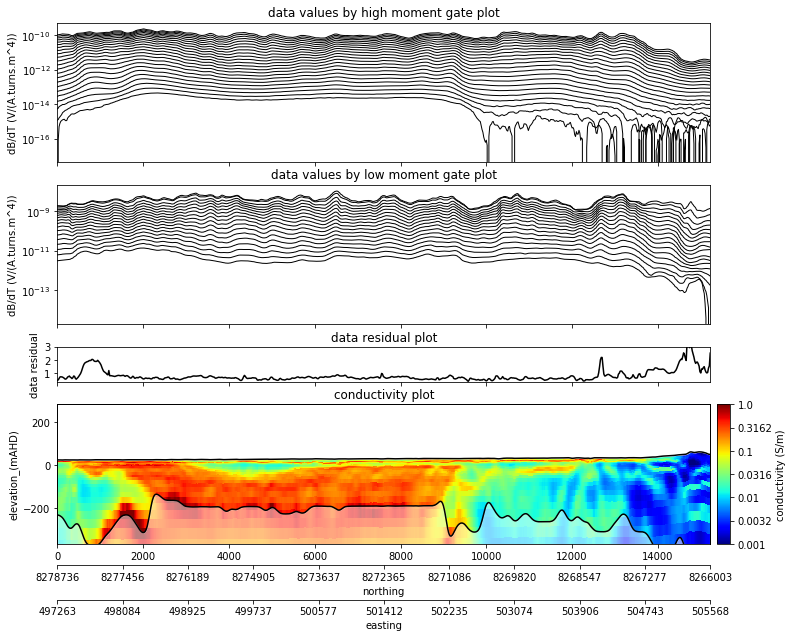

In [72]:
# Now lets plot with the data over the top
import matplotlib as mpl

panel_settings = {'panel_1': {'variable': 'data_values_by_high_moment_gate',
                              'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'high moment data',
                                             'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 2},
                  
                 'panel_2': {'variable': 'data_values_by_low_moment_gate',
                             'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'low moment data',
                                              'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 2},
                  
                 'panel_3': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 0.5},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration': 5.},
                             'height_ratio': 2}}



height_ratios = plot_utils.unpack_plot_settings(panel_settings,'height_ratio')


plot_settings = {'bottom_margin': 1.5, 'top_margin': 1.,
                    'panel_vgap': 1.5, 'plot_width': 11.7 #A3 width
                }

for line in lines:
    
    plt.close()

    

    fig, ax_array = plt.subplots(len(panel_settings),1, sharex = True,
                                gridspec_kw={'height_ratios': height_ratios,
                                            'wspace':plot_settings['panel_vgap']})

    plot_objs = plot_conductivity_section(ax_array, gridded_vars[line], plot_settings,
                                         panel_settings, save_fig = False)
     
    
    # Set the aspect based on the vertical exageration
    
    format_panels(ax_array, panel_settings, plot_settings)
    
    
    # Add axes to the bottom
    

    
    # Add colourbar
    #plt.colorbar(fig, ax=ax_array, shrink=0.45, anchor=(0, 0), aspect=10)
    
    
    fig.tight_layout()
    
    # Now we want to add the colorbar and coordinates axes
    
    cm = plt.cm.get_cmap('jet')
    
    
    # You input the POSITION AND DIMENSIONS RELATIVE TO THE AXES
    x0, y0, width, height = [1.011, 0., 0.02, 1.
                            ]

    # and transform them after to get the ABSOLUTE POSITION AND DIMENSIONS
    Bbox = mpl.transforms.Bbox.from_bounds(x0, y0, width, height)
    trans = ax_array[-1].transAxes + fig.transFigure.inverted()
    l, b, w, h = mpl.transforms.TransformedBbox(Bbox, trans).bounds

    # Now just create the axes and the colorbar
    cbaxes = fig.add_axes([l, b, w, h])
    cb = plt.colorbar(plot_objs[-1], cax=cbaxes, orientation='vertical')
    cb.ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])
    cb.ax.tick_params(labelsize=9)
    cb_label = 'conductivity (S/m)'
    cb.set_label(cb_label, fontsize=10)
    cb.ax.tick_params(labelsize=10)
    #ax_pos = plot_utils.align_axes(ax_array)
    
    add_axis_coords('northing', gridded_vars[line]['northing'],
                               ax_array[-1], ax_pos[len(panel_settings) - 1], offset=-0.15)

    add_axis_coords('easting', gridded_vars[line]['easting'], ax_array[-1],
                               ax_pos[len(panel_settings) - 1], offset=-0.4)
    
    
    plt.savefig(r'C:\Temp\gridtest.png')
    
    plt.show()

In [66]:
dir(cbar.ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',
 '_oid',
 '_on_units_changed',
 '_o